<a href="https://colab.research.google.com/github/gomesluiz/pln-na-pratica/blob/main/01-aquisicao-dados-enriquecimento-de-dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aquisição de dados com enriquecimento de dados**

In [178]:
# Instala pacotes para análise de dados e raspagem web.
!pip install kaggle
!pip install matplotlib
!pip install nlpaug
!pip install numpy
!pip install pandas
!pip install requests
!pip install scikit-learn
!pip install seaborn
!pip install tqdm

In [209]:
# Declara define funções utilitárias utilizadas no notebook.
import datetime
def formata_msg(nivel, msg, componente=None):
    """
    Formata uma mensagem de log incluindo o nível de severidade, timestamp,
    componente (opcional) e a mensagem.

    Parâmetros:
    - nivel (str): Nível de severidade da mensagem (ex: 'INFO', 'ERROR', 'WARNING').
    - msg (str): A mensagem de log propriamente dita.
    - componente (str, opcional): O componente ou módulo do sistema que gera a mensagem.

    Retorna:
    - str: A mensagem de log formatada.
    """
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    if componente:
        return f"[{nivel}] {timestamp} - {componente}: {msg}"
    else:
        return f"[{nivel}] {timestamp} - {msg}"

def plotar_distribuicao_polaridade(df):
    """
    Função para plotar um gráfico de barras da contagem de valores para a coluna 'polarity'.

    Parâmetros:
    df (DataFrame): O DataFrame contendo a coluna 'polarity' a ser analisada.

    Esta função utiliza a biblioteca seaborn para criar um gráfico de barras que
    mostra a contagem de ocorrências para cada valor único na coluna 'polarity'.
    Os rótulos dos eixos são removidos para uma apresentação mais limpa, e as bordas
    esquerdas são também removidas.
    """

    # Realiza a contagem de valores na coluna 'polarity' e armazena o resultado
    polarity_counts = df['polarity'].value_counts()

    # Cria o gráfico de barras usando seaborn, definindo os valores do eixo x e y
    sns.barplot(x=polarity_counts.index, y=polarity_counts, hue=polarity_counts.index, legend=False)

    # Configurações para remover rótulos e títulos desnecessários do gráfico
    plt.yticks([], [])  # Remove os rótulos do eixo y para simplificar a visualização
    plt.xlabel('')      # Limpa o título do eixo x para uma apresentação mais limpa
    plt.ylabel('')      # Limpa o título do eixo y para uma apresentação mais limpa
    sns.despine(left=True)  # Remove a borda esquerda do gráfico para um design mais minimalista

    # Loop para adicionar rótulos de texto em cada barra do gráfico, melhorando a interpretabilidade
    for container in plt.gca().containers:
        plt.gca().bar_label(container)  # Adiciona rótulos nas barras com a contagem de cada 'polarity'


In [210]:
# Importa módulos essenciais para funcionalidades do notebook.
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

from sklearn.model_selection import train_test_split

import nlpaug.augmenter.word as naw

timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(formata_msg("INFO", "Bibliotecas importadas com sucesso; ambiente pronto."))

[INFO] 2024-02-04 03:56:36 - Bibliotecas importadas com sucesso; ambiente pronto.


In [211]:
# Define o diretório local para armazenar as bases de dados públicas coletadas.
corpora_caminho = "./corpora"

# Verifica se o diretório especificado já existe no ambiente do Colab.
if not os.path.exists(corpora_caminho):
  # Caso o diretório não exista, cria um novo diretório com o nome 'corpora'.
  # Isso é útil para organizar os arquivos de dados baixados ou gerados.
  os.mkdir(corpora_caminho)

print(formata_msg("INFO", f"Diretório {corpora_caminho} foi criado com sucesso."))

[INFO] 2024-02-04 03:56:43 - Diretório ./corpora foi criado com sucesso.


## Base de dados de comentários do Buscapé
Buscapé é uma plataforma de comércio eletrônico brasileiro. O Buscapé funciona como um assistente de compras, para que os consumidores pesquisem produtos, preços, promoções e lojas.O Buscapé pertence à Mosaico Tecnologia ao Consumidor, que também é dona de outras plataformas de e-commerce.

In [213]:
# Define a URL da base pública armazenada no Github.
url = "https://raw.githubusercontent.com/gomesluiz/product-review-analytics/main/data/raw/buscape.csv"

# Configuração do arquivo para armazenamento da base de dados.
buscape_arquivo = "buscape-comentarios.csv"

# O método os.path.join cria o caminho completo para o arquivo, combinando
# 'corpora_caminho' com o nome do arquivo.
buscape_caminho = os.path.join(corpora_caminho, buscape_arquivo)

# Define o formato do arquivo. Necessário para arquivos textos
# armazenados no raw.githubusercontent.com.
parametros = {"downloadformat": "csv"}

# Executa o download do arquivo especificado na URL com os parâmetros
# especificados
resposta = requests.get(url, params=parametros)
if resposta.status_code == 200:
  # Se o status for igual a 200 (sucesso), grava o arquivo no caminho
  # especificado
  with open(buscape_caminho, "wb") as f:
    f.write(resposta.content)
  print(formata_msg("INFO",f"Download do arquivo {buscape_arquivo} concluído com sucesso!"))
else:
  print(f"Falha no download do arquivo {buscape_arquivo}:", resposta.status_code)


[INFO] 2024-02-04 03:57:00 - Download do arquivo buscape-comentarios.csv concluído com sucesso!


In [214]:
# O comando head do linux mostra as cinco primeiras linhas do arquivo gravado.
!head -n 5 {buscape_caminho}

original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
4_55516,"Estou muito satisfeito, o visor é melhor do que eu imaginava, boas imagens, desing ultra fino. Pelo preço é um exelente aparelho.

O que gostei: Desing exelente, display, custo beneficio.



In [215]:
# Lista das colunas específicas para serem lidas do arquivo CSV.
colunas_desejadas = ['review_text', 'polarity']

# Carrega dados do CSV usando as colunas definidas.
buscape_df = pd.read_csv(buscape_caminho, usecols=colunas_desejadas)

# Mostra o número de linhas e colunas do dataFrame buscape_df.
num_rows, num_cols = buscape_df.shape[0], buscape_df.shape[1]
print(formata_msg("INFO", f"The dataset has {num_rows} rows and {num_cols} columns."))

[INFO] 2024-02-04 03:57:08 - The dataset has 84991 rows and 2 columns.


In [216]:
# Remove todas as linhas do DataFrame que contêm valores nulos.
buscape_df.dropna(inplace=True)

# Mostra o número de linhas e colunas do dataFrame buscape_df.
num_rows, num_cols = buscape_df.shape[0], buscape_df.shape[1]
print(formata_msg("INFO", f"The dataset has {num_rows} rows and {num_cols} columns."))

[INFO] 2024-02-04 03:57:11 - The dataset has 73626 rows and 2 columns.


In [217]:
# Exibe as primeiras 5 linhas do DataFrame 'buscape_df' para uma rápida inspeção.
buscape_df.head()

,review_text,polarity
0,"Estou muito satisfeito, o visor é melhor do qu...",1.0
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1.0
2,"Rápida, ótima qualidade de impressão e fácil d...",1.0
3,Produto de ótima qualidade em todos os quesito!,1.0
4,Precisava comprar uma tv compatível com meu dv...,1.0


In [218]:
# Converte os valores da coluna 'polarity' para string.
buscape_df['polarity'] = buscape_df['polarity'].astype(int)

# Exibe as primeiras 5 linhas do DataFrame 'buscape_df' para uma rápida inspeção.
buscape_df.head()

,review_text,polarity
0,"Estou muito satisfeito, o visor é melhor do qu...",1
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1
2,"Rápida, ótima qualidade de impressão e fácil d...",1
3,Produto de ótima qualidade em todos os quesito!,1
4,Precisava comprar uma tv compatível com meu dv...,1


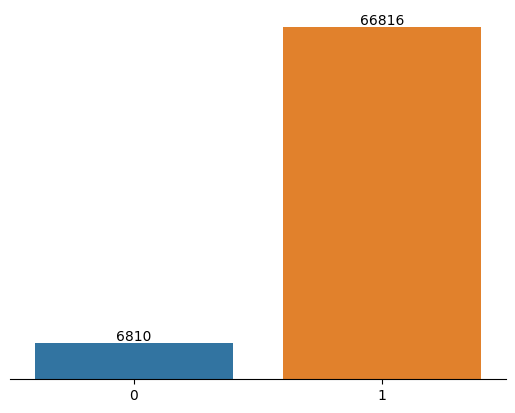

In [219]:
# Plota um gráfico de barras as categorias de polaridade.
plotar_distribuicao_polaridade(buscape_df)

In [220]:
# Seleciona uma linha específica do dataFrame 'buscape_df' usando 'iloc' para
# testes do enriquecimento de dados.
texto = buscape_df.iloc[5]['review_text'].replace("\n", " ")
print(texto)

eu adorei este secador é muito bom,potente e deixa meu cabelo lindo


In [221]:
# O objeto SynonymAug é configurado para enriquecer textos através da
# substituição de palavras por seus sinônimos, utilizando a base de dados
# 'wordnet'. O parâmetro 'lang' define o idioma dos sinônimos como Português
# ('por'), e 'verbose=0' desativa mensagens adicionais durante a execução.
aug = naw.SynonymAug(aug_src='wordnet', lang='por', verbose=0)

print("Texto enriquecido:")
for ii in range(5):
    # 'aug.augment(texto)' aplica o enriquecimento ao texto original, substituindo
    # algumas palavras por seus sinônimos
    print(aug.augment(texto))


Texto enriquecido:
['eu adorei leste secador é muito bom, potente e deixa meu cabelo lindo']
['eu adorei este secador é muito bom, potente e deixa meu pelo lindo']
['eu adorei leste secador é muito bom, potente e deixa meu cabelo lindo']
['eu adorei este secador é muito bom, potente e deixa meu cabelo lindo']
['eu adorei leste secador é muito bom, potente e deixa meu pêlo lindo']


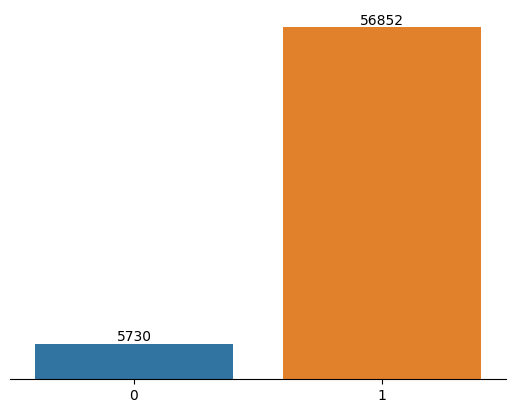

In [226]:
from tqdm import tqdm
from random import shuffle

def enriquecer_texto(df, amostras=300, prob_aug=0.2):
    aug.aug_p = prob_aug  # Define a probabilidade de augmentação de texto
    novos_textos = []  # Lista para armazenar textos aumentados

    # Seleciona amostras da classe minoritária (polaridade = 0)
    df_minoritario = df[df.polarity == 0].reset_index(drop=True)

    # Loop de augmentação de dados
    for i in tqdm(np.random.randint(0, len(df_minoritario), amostras)):
        texto = df_minoritario.iloc[i]['review_text']  # Seleciona um texto
        texto_aumentado = aug.augment(texto)  # Aplica augmentação
        novos_textos.append(texto_aumentado)  # Adiciona ao conjunto de novos textos

    # Cria um DataFrame com os novos textos e a polaridade 0
    novos_df = pd.DataFrame({'review_text': novos_textos, 'polarity': 0})

    # Combina o DataFrame original com o novo e reorganiza os índices
    df = pd.concat([df, novos_df], ignore_index=True)
    return df

# Divisão do DataFrame 'buscape_df' em conjuntos de treino e teste.
train, test = train_test_split(buscape_df, test_size=0.15, random_state=1)

# plotar a distribuição de polaridade no conjunto de treino
plotar_distribuicao_polaridade(train)

In [229]:
# Enriquece o conjunto de treinamento. Esse procedimento não
# ser aplicado somente no conjunto de testes. Esse
# deve refletir dados do mundo real tão fielmente quanto possível.
train = enriquecer_texto(train)

100%|██████████| 300/300 [00:01<00:00, 268.68it/s]


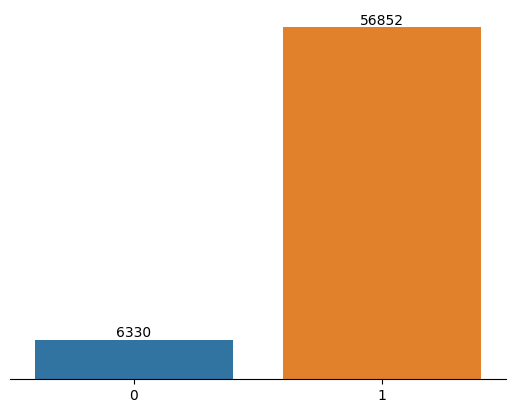

In [230]:
# plotar a distribuição de polaridade no conjunto de treino
# após o enriquecimento.
plotar_distribuicao_polaridade(train)